In [2]:
# Importing Required Libraries
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from sqlite3 import connect

In [3]:
# Setting Up Visualization and Warnings
sns.set(color_codes=True)
plt.style.use('ggplot')
%matplotlib inline
warnings.filterwarnings('ignore')

In [5]:
# Loading the Dataset
ecomm_data = pd.read_csv('/Users/neha/projects/eda analysis/US  E-commerce records 2020.csv', encoding='latin1')

# Checking Introductory Details About Data
print("First 5 Rows:")
print(ecomm_data.head())
print("\nLast 5 Rows:")
print(ecomm_data.tail())
print("\nDataset Shape:", ecomm_data.shape)
print("\nDataset Info:")
print(ecomm_data.info())
print("\nMissing Values:")
print(ecomm_data.isnull().sum())

First 5 Rows:
  Order Date  Row ID        Order ID       Ship Mode Customer ID      Segment  \
0   01-01-20     849  CA-2017-107503  Standard Class    GA-14725     Consumer   
1   01-01-20    4010  CA-2017-144463  Standard Class    SC-20725     Consumer   
2   01-01-20    6683  CA-2017-154466     First Class    DP-13390  Home Office   
3   01-01-20    8070  CA-2017-151750  Standard Class    JM-15250     Consumer   
4   01-01-20    8071  CA-2017-151750  Standard Class    JM-15250     Consumer   

         Country         City       State  Postal Code   Region  \
0  United States       Lorain        Ohio        44052     East   
1  United States  Los Angeles  California        90036     West   
2  United States     Franklin   Wisconsin        53132  Central   
3  United States   Huntsville       Texas        77340  Central   
4  United States   Huntsville       Texas        77340  Central   

        Product ID         Category Sub-Category  \
0  FUR-FU-10003878        Furniture  Furnish

In [6]:
# Checking the column names of the dataset
print(ecomm_data.columns)

Index(['Order Date', 'Row ID', 'Order ID', 'Ship Mode', 'Customer ID',
       'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region',
       'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales',
       'Quantity', 'Discount', 'Profit'],
      dtype='object')


In [7]:
# Identifying Categorical and Numerical Features
categoricals = ecomm_data.dtypes[ecomm_data.dtypes == 'object'].index.tolist()
numericals = ecomm_data.dtypes[ecomm_data.dtypes != 'object'].index.tolist()
print('\nCategorical Features:', categoricals)
print('Numerical Features:', numericals)

# Dropping Irrelevant Columns
ecomm_data = ecomm_data.drop(['Country', 'Row ID', 'Postal Code'], axis=1)

# Converting 'Order Date' to Datetime and Extracting Month and Day of Week
ecomm_data['Order Date'] = pd.to_datetime(ecomm_data['Order Date'], format="%d-%m-%y")
ecomm_data['Month'] = ecomm_data['Order Date'].dt.strftime("%m")
ecomm_data['Day of Week'] = ecomm_data['Order Date'].dt.dayofweek

# Mapping Month and Day of Week to Names
month_map = {'01': 'January', '02': 'February', '03': 'March', '04': 'April', '05': 'May', '06': 'June',
             '07': 'July', '08': 'August', '09': 'September', '10': 'October', '11': 'November', '12': 'December'}
day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
ecomm_data['Month'] = ecomm_data['Month'].replace(month_map)
ecomm_data['Day of Week'] = ecomm_data['Day of Week'].replace(day_map)


Categorical Features: ['Order Date', 'Order ID', 'Ship Mode', 'Customer ID', 'Segment', 'Country', 'City', 'State', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name']
Numerical Features: ['Row ID', 'Postal Code', 'Sales', 'Quantity', 'Discount', 'Profit']


In [9]:
# Adding State Codes for Visualization
state_codes = {
    'District of Columbia': 'dc', 'Mississippi': 'MS', 'Oklahoma': 'OK', 'Delaware': 'DE', 'Minnesota': 'MN',
    'Illinois': 'IL', 'Arkansas': 'AR', 'New Mexico': 'NM', 'Indiana': 'IN', 'Maryland': 'MD', 'Louisiana': 'LA',
    'Idaho': 'ID', 'Wyoming': 'WY', 'Tennessee': 'TN', 'Arizona': 'AZ', 'Iowa': 'IA', 'Michigan': 'MI', 'Kansas': 'KS',
    'Utah': 'UT', 'Virginia': 'VA', 'Oregon': 'OR', 'Connecticut': 'CT', 'Montana': 'MT', 'California': 'CA',
    'Massachusetts': 'MA', 'West Virginia': 'WV', 'South Carolina': 'SC', 'New Hampshire': 'NH', 'Wisconsin': 'WI',
    'Vermont': 'VT', 'Georgia': 'GA', 'North Dakota': 'ND', 'Pennsylvania': 'PA', 'Florida': 'FL', 'Alaska': 'AK',
    'Kentucky': 'KY', 'Hawaii': 'HI', 'Nebraska': 'NE', 'Missouri': 'MO', 'Ohio': 'OH', 'Alabama': 'AL',
    'Rhode Island': 'RI', 'South Dakota': 'SD', 'Colorado': 'CO', 'New Jersey': 'NJ', 'Washington': 'WA',
    'North Carolina': 'NC', 'New York': 'NY', 'Texas': 'TX', 'Nevada': 'NV', 'Maine': 'ME'}
ecomm_data['State Code'] = ecomm_data['State'].apply(lambda x: state_codes[x])

# Checking for Duplicate Rows
duplicate_rows = ecomm_data[ecomm_data.duplicated()]
print("\nNumber of Duplicate Rows:", duplicate_rows.shape)

# Connecting to SQLite for SQL Queries
conn = connect(':memory:')
ecomm_data.to_sql('ecomm_data', conn, index=False, if_exists='replace')



Number of Duplicate Rows: (0, 19)


3312

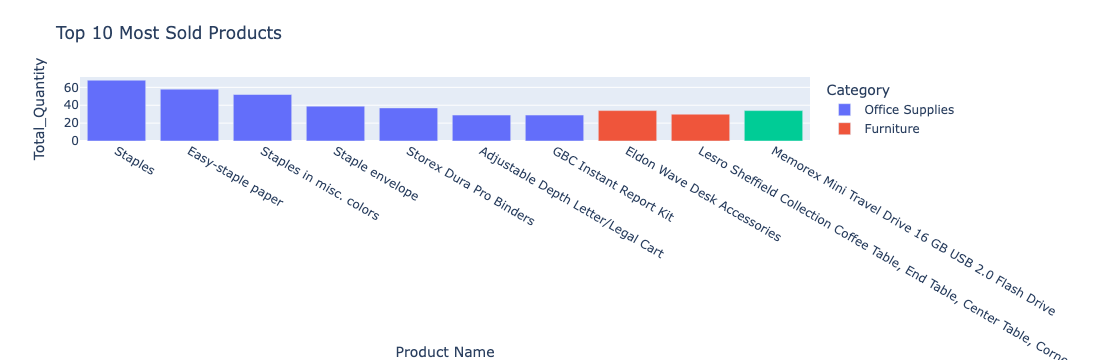

In [10]:

# Analyzing Top 10 Most Sold Products
top_products = pd.read_sql("SELECT `Product Name`, Category, SUM(Quantity) AS Total_Quantity FROM ecomm_data GROUP BY `Product Name`, Category ORDER BY Total_Quantity DESC LIMIT 10", conn)
fig = px.bar(top_products, x='Product Name', y='Total_Quantity', color='Category', title='Top 10 Most Sold Products')
fig.show()


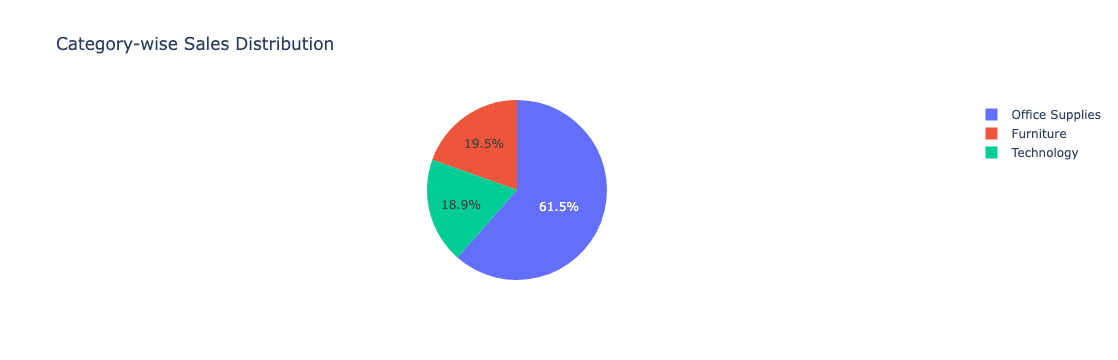

In [11]:
# Analyzing Category-wise Sales Distribution
category_sales = pd.read_sql("SELECT Category, SUM(Quantity) AS Total_Quantity FROM ecomm_data GROUP BY Category", conn)
fig = px.pie(category_sales, names='Category', values='Total_Quantity', title='Category-wise Sales Distribution')
fig.show()


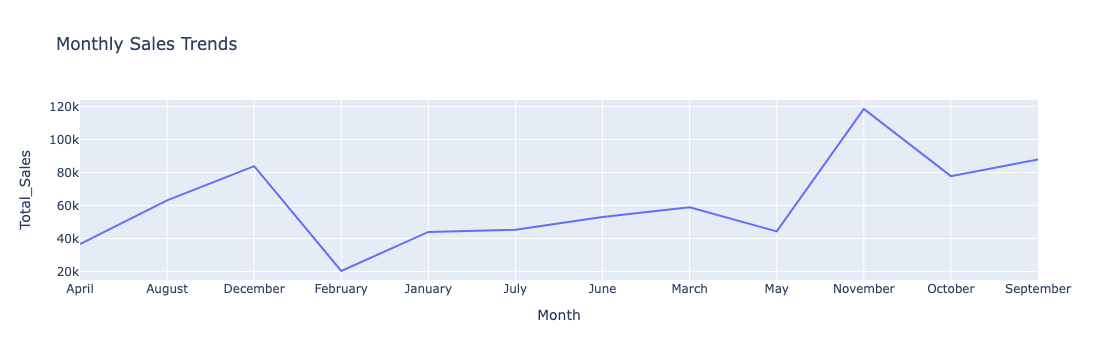

In [12]:
# Analyzing Monthly Sales Trends
monthly_sales = pd.read_sql("SELECT Month, SUM(Sales) AS Total_Sales, SUM(Quantity) AS Total_Quantity FROM ecomm_data GROUP BY Month", conn)
fig = px.line(monthly_sales, x='Month', y='Total_Sales', title='Monthly Sales Trends')
fig.show()

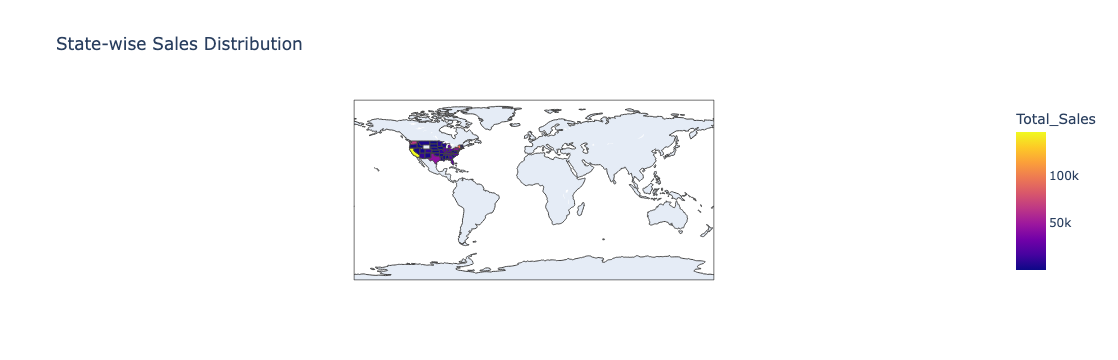

In [14]:
# Correcting the SQL query with double quotes for column names with spaces
state_sales = pd.read_sql('''
    SELECT "State", "State Code", SUM(Sales) AS Total_Sales
    FROM ecomm_data
    GROUP BY "State", "State Code"
''', conn)

# Plotting the result
fig = px.choropleth(state_sales, locations='State Code', locationmode='USA-states', color='Total_Sales', hover_name='State', title='State-wise Sales Distribution')
fig.show()


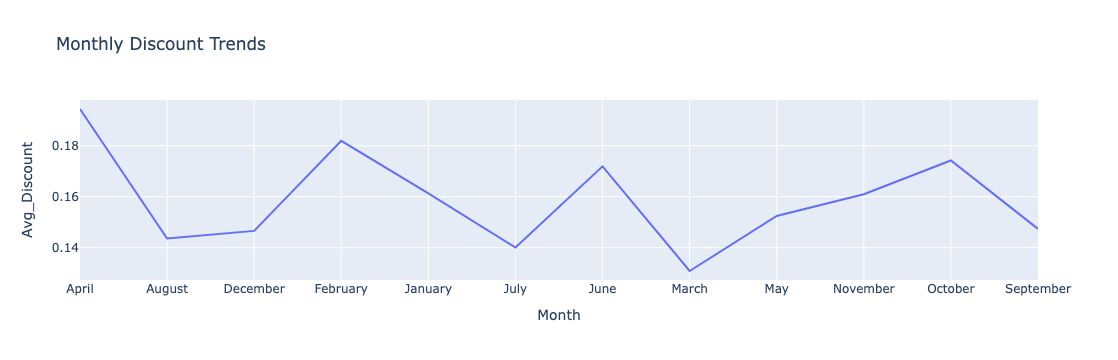

In [15]:

# Analyzing Discount Trends
discount_trends = pd.read_sql("SELECT Month, AVG(Discount) AS Avg_Discount FROM ecomm_data GROUP BY Month", conn)
fig = px.line(discount_trends, x='Month', y='Avg_Discount', title='Monthly Discount Trends')
fig.show()
